# Time series analysis sample (Bike Sharing Data)

- Bike Sharing Dataset Data Set https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from prophet import Prophet

from sklearn.metrics import r2_score

Importing plotly failed. Interactive plots will not work.


In [2]:
# Dataset
DF_RAW = pd.read_csv(
    "day.csv",
    parse_dates=[1]
)

In [3]:
# Number of days used for prediction (from November to December, 2 month).
NOVEMBER_AND_DECEMBER_DAYS: int = 30 + 31

In [4]:
# Methods
def calc_r2_and_display(y_test_input, y_pred_input) -> None:
    """Calculate R2 value and display."""
    score = r2_score(y_test_input, y_pred_input)
    print(f'R2 score: {score:.4f}')


In [5]:
# Prepare dataset to use.
display(DF_RAW.head(3))
display(DF_RAW.tail(3))

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [6]:
# Data preprocessing and splitting.
df = DF_RAW[
    ['dteday', 'registered']
]

# Prepare `ds`, `y`, following Prophet's style.
df.columns = ['ds', 'y']

display(df.head())

,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518


In [7]:
day_border = pd.to_datetime('2012-11-01')
index_train = df['ds'] < day_border
index_test = df['ds'] >= day_border

X_train = df[index_train]
X_test = df[index_test]
date_test = df['ds'][index_test]

In [8]:
# Using model Prophet.
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
model.fit(X_train)

21:03:38 - cmdstanpy - INFO - Chain [1] start processing
21:03:38 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Prediction.

# Following Prophet's style, we create a data (named `future`) that contains only dates as an array \
#  and use it as input for prediction.
future = model.make_future_dataframe(
    periods=NOVEMBER_AND_DECEMBER_DAYS,
    freq='D'
)

display(future.head())
display(future.tail())

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05


,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


In [10]:
pred = model.predict(future)

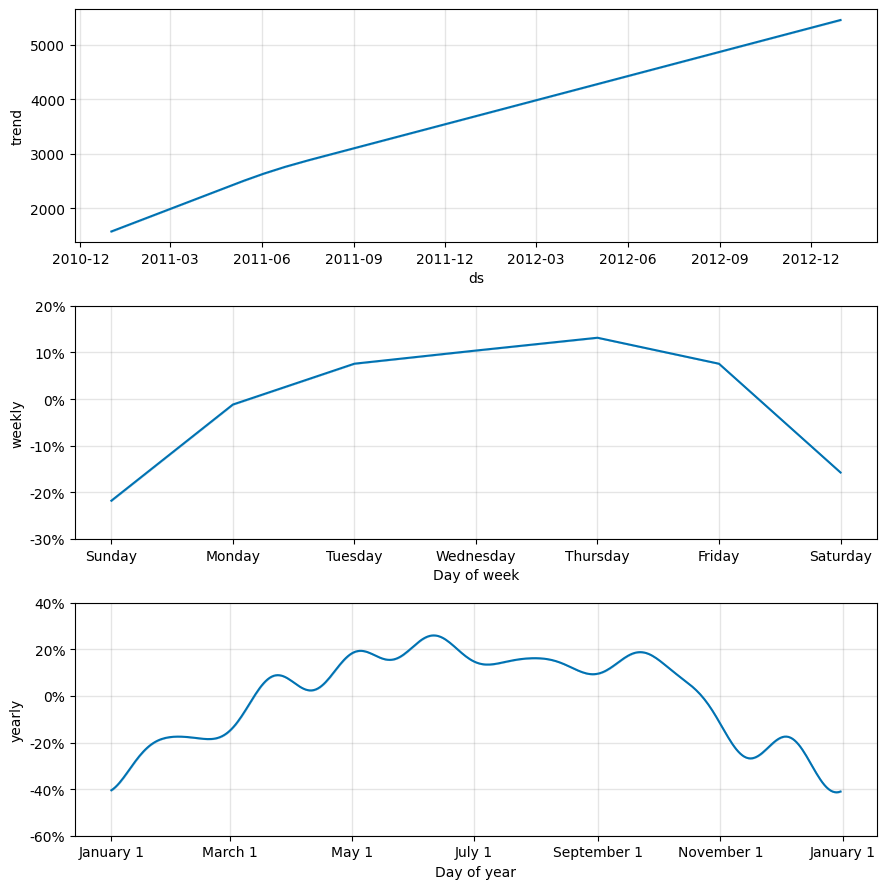

In [11]:
# Evaluation.
fig = model.plot_components(pred)
plt.show()

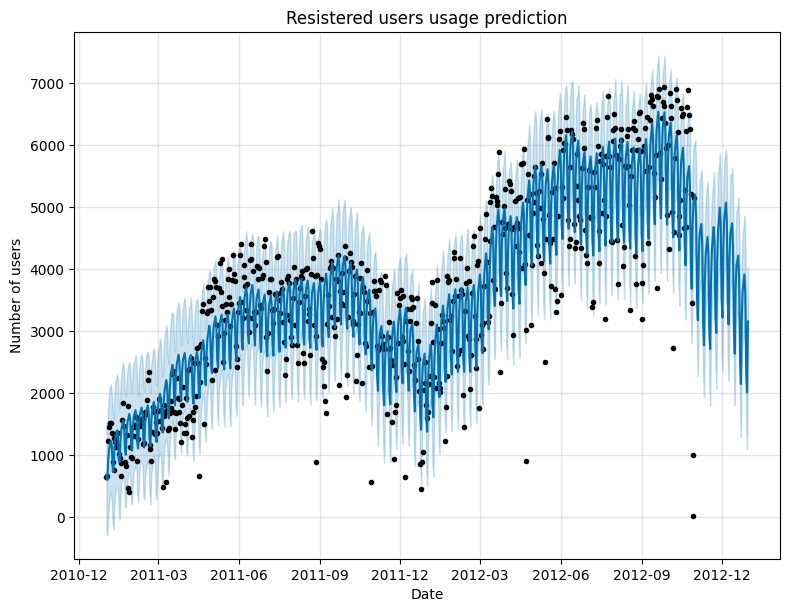

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

model.plot(pred, ax=ax)
ax.set_title('Resistered users usage prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Number of users')
plt.show()

In [13]:
# Calc R2.
y_pred = pred[-(NOVEMBER_AND_DECEMBER_DAYS):][
    ['yhat']
].values
y_test = X_test['y'].values

calc_r2_and_display(y_test, y_pred)

R2 score: 0.3736


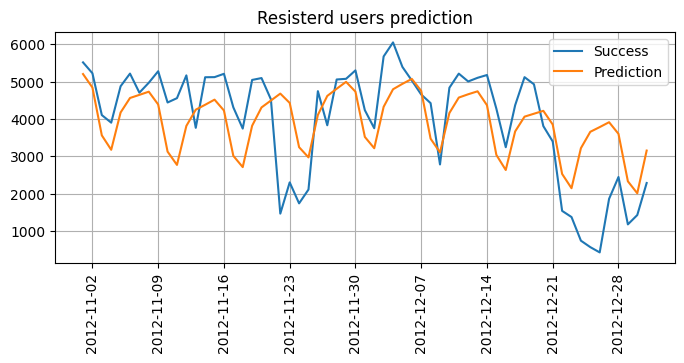

In [14]:
# Show resisterd users prediction.
weeks = mdates.WeekdayLocator(byweekday=mdates.FR)

fig, ax = plt.subplots(figsize=(8, 3))
ax.grid()
ax.plot(
    date_test,
    y_test,
    label='Success'
)
ax.plot(
    date_test,
    y_pred,
    label='Prediction'
)
ax.xaxis.set_major_locator(weeks)
ax.tick_params(
    axis='x',
    rotation=90
)
ax.set_title('Resisterd users prediction')
ax.legend()
plt.show()

In [15]:
# Model tuning.
df_holidays = DF_RAW[
    DF_RAW['holiday']==1
]
holidays = df_holidays['dteday'].values

df_extended = pd.DataFrame({
    'holiday': 'holiday',
    'ds': holidays,
    'lower_window': 0,
    'upper_window': 0,
})

display(df_extended.head())
display(df_extended.tail())

,holiday,ds,lower_window,upper_window
0,holiday,2011-01-17,0,0
1,holiday,2011-02-21,0,0
2,holiday,2011-04-15,0,0
3,holiday,2011-05-30,0,0
4,holiday,2011-07-04,0,0


,holiday,ds,lower_window,upper_window
16,holiday,2012-09-03,0,0
17,holiday,2012-10-08,0,0
18,holiday,2012-11-12,0,0
19,holiday,2012-11-22,0,0
20,holiday,2012-12-25,0,0


21:03:39 - cmdstanpy - INFO - Chain [1] start processing
21:03:39 - cmdstanpy - INFO - Chain [1] done processing


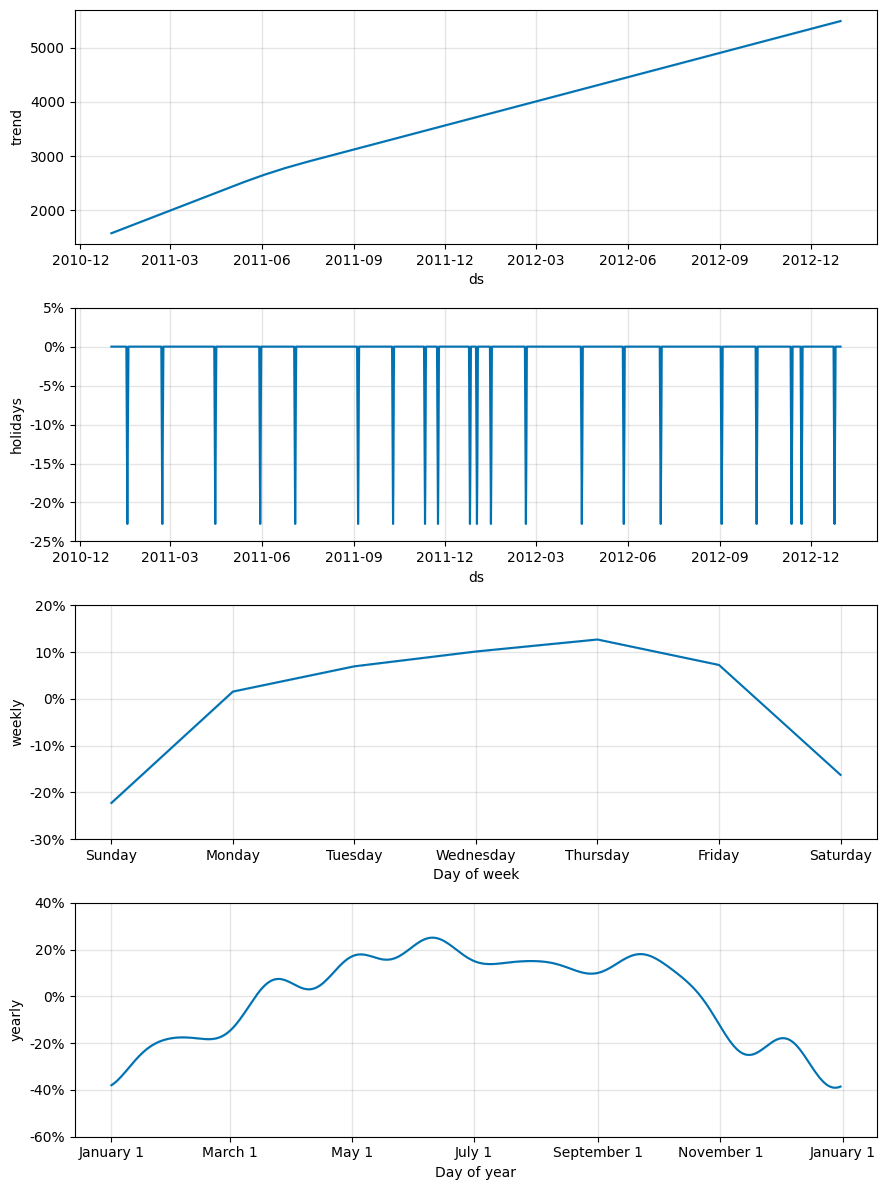

In [16]:
model_2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=df_extended,
    seasonality_mode='multiplicative'
)
model_2.fit(X_train)

pred_2 = model_2.predict(future)

# Evaluation.
fig = model_2.plot_components(pred_2)
plt.show()

In [17]:
# Calc R2.
y_pred_2 = pred_2[-(NOVEMBER_AND_DECEMBER_DAYS):][
    ['yhat']
].values

calc_r2_and_display(y_test, y_pred_2)

R2 score: 0.4146


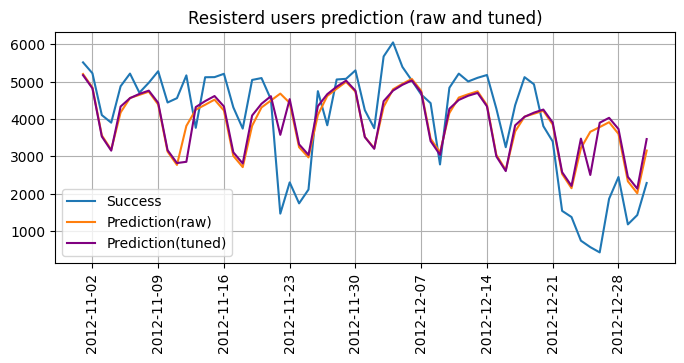

In [18]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.grid()
ax.plot(
    date_test,
    y_test,
    label='Success'
)
ax.plot(
    date_test,
    y_pred,
    label='Prediction(raw)'
)
ax.plot(
    date_test,
    y_pred_2,
    label='Prediction(tuned)',
    c='purple'
)
ax.xaxis.set_major_locator(weeks)
ax.tick_params(
    axis='x',
    rotation=90
)
ax.set_title('Resisterd users prediction (raw and tuned)')
ax.legend()
plt.show()

In [19]:
# Model re-tuning.
weather_related_items = ['weathersit', 'temp', 'windspeed', 'hum']

df_re_tuned = pd.concat([
    df,
    DF_RAW[weather_related_items]
], axis=1)

X_train_re_tuned = df_re_tuned[index_train]
X_test_re_tuned = df_re_tuned[index_test]

display(X_train_re_tuned.tail())

,ds,y,weathersit,temp,windspeed,hum
665,2012-10-27,5209,2,0.530000,0.235692,0.720000
666,2012-10-28,3461,2,0.477500,0.398008,0.694583
667,2012-10-29,20,3,0.440000,0.358200,0.880000
668,2012-10-30,1009,2,0.318182,0.213009,0.825455
669,2012-10-31,5147,2,0.357500,0.166667,0.666667


In [20]:
model_3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=df_extended,
    seasonality_mode='multiplicative'
)

for item in weather_related_items:
    model_3.add_regressor(item)

model_3.fit(X_train_re_tuned)

21:03:41 - cmdstanpy - INFO - Chain [1] start processing
21:03:41 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
future_3 = df_re_tuned[
    ['ds'] + weather_related_items
]
pred_3 = model_3.predict(future_3)

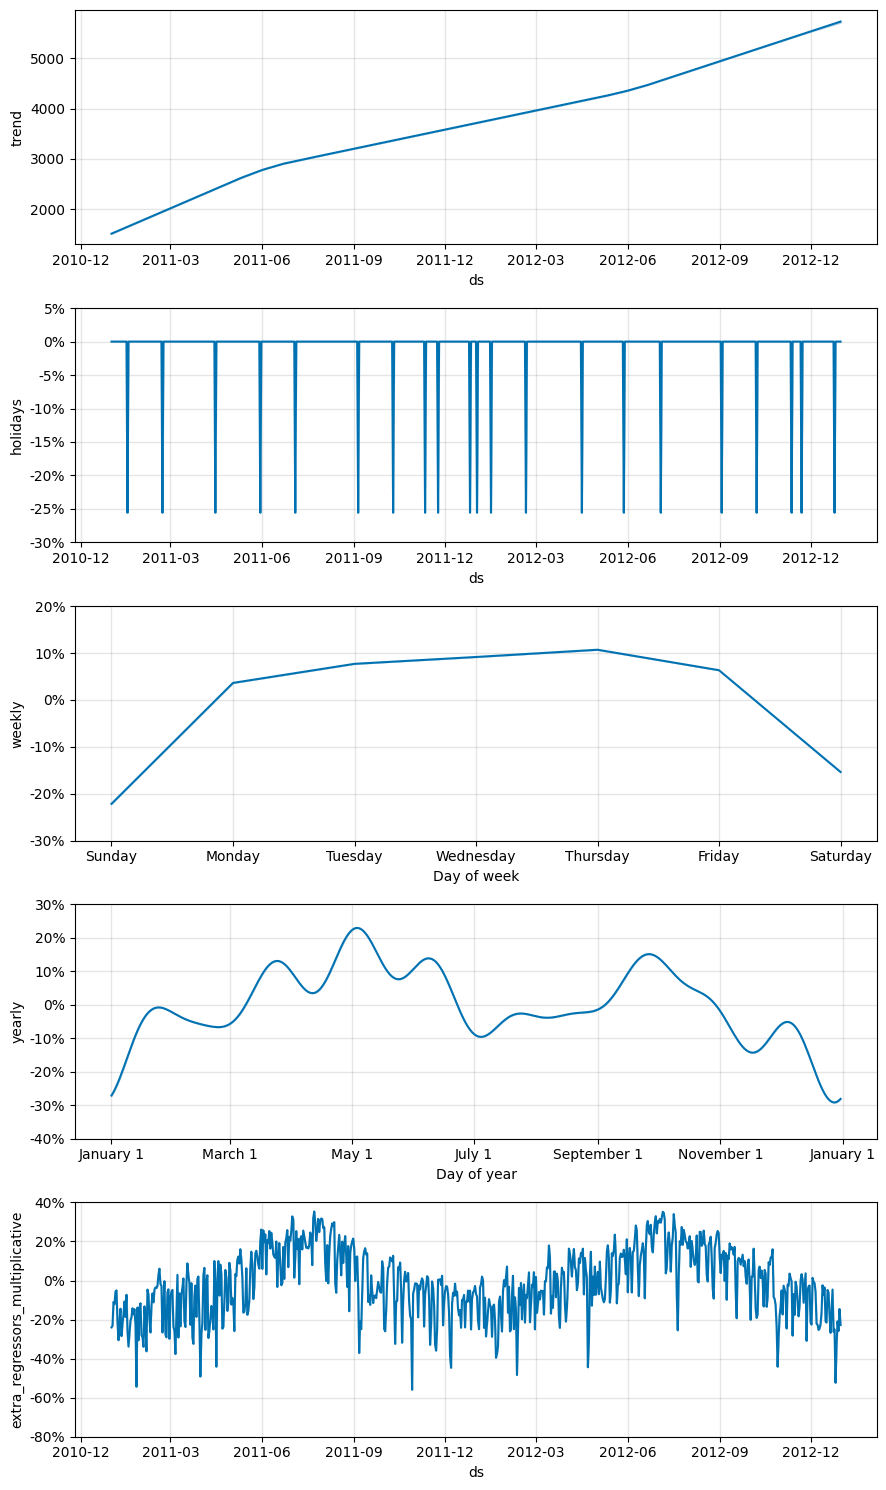

In [22]:
# Evaluation.
fig = model_3.plot_components(pred_3)
plt.show()

In [23]:
# Calc R2.
y_pred_3 = pred_3[-(NOVEMBER_AND_DECEMBER_DAYS):][
    ['yhat']
].values

calc_r2_and_display(y_test, y_pred_3)

R2 score: 0.6196


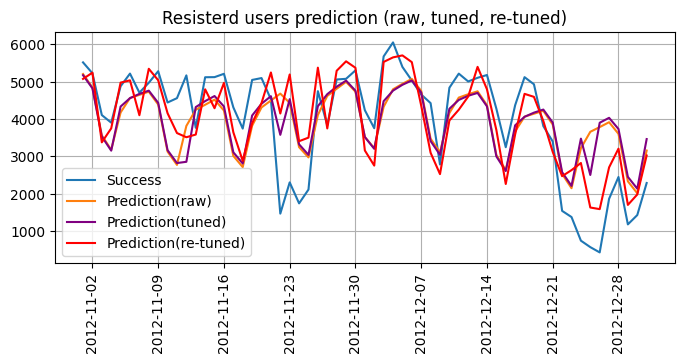

In [24]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.grid()
ax.plot(
    date_test,
    y_test,
    label='Success'
)
ax.plot(
    date_test,
    y_pred,
    label='Prediction(raw)'
)
ax.plot(
    date_test,
    y_pred_2,
    label='Prediction(tuned)',
    c='purple'
)
ax.plot(
    date_test,
    y_pred_3,
    label='Prediction(re-tuned)',
    c='red'
)
ax.xaxis.set_major_locator(weeks)
ax.tick_params(
    axis='x',
    rotation=90
)
ax.set_title('Resisterd users prediction (raw, tuned, re-tuned)')
ax.legend()
plt.show()

R2 was also significantly improved, indicating that tuning has increased the effectiveness of the time series analysis.